In [318]:
import pandas as pd
import numpy as np
import ast
from typing import Dict, List

from tqdm import tqdm

pd.set_option("display.precision", 6)
pd.set_option("display.max_columns", None)
pd.options.mode.chained_assignment = None

# Предварительная обработка данных

## Предобработка данных о бойцах

### Загрузка данных в датафрейм из csv

In [319]:
fighters_df = pd.read_csv("data/0.fighters_raw.csv", index_col=0)
fighters_df["dateOfBirth"] = pd.to_datetime(fighters_df["dateOfBirth"])
fighters_cols = [
    "id",
    "name",
    "weight",
    "height",
    "armSpan",
    "legSwing",
    "weightCategory.id",
    "weightCategory.name",
    "dateOfBirth",
    "country",
    "city",
    "timezone",
]
fighters_df = fighters_df[fighters_cols]
fighters_df.set_index("id", inplace=True)
fighters_df.head(5)

,name,weight,height,armSpan,legSwing,weightCategory.id,weightCategory.name,dateOfBirth,country,city,timezone
id,,,,,,,,,,,
1,Tanner Boser,115.67,187.96,190.50,NaN,9,Тяжелый вес,1991-08-02,Canada,Bonnyville,America/Edmonton
2,Giacomo Lemos,112.04,190.50,190.50,NaN,9,Тяжелый вес,1989-06-23,Brazil,NaN,America/Sao_Paulo
3,Shamil Abdurakhimov,106.59,190.50,193.04,105.41,9,Тяжелый вес,1981-09-02,Dagestan,Makhachkala,Europe/Moscow
4,Klidson Abreu,92.99,182.88,187.96,NaN,8,Полутяжелый вес,1992-12-24,Brazil,Manaus,America/Manaus
5,Yoshihiro Akiyama,77.11,177.80,190.50,106.68,6,Полусредний вес,1975-07-29,Japan,Ikuno,Asia/Tokyo


### Исправляем поле `country` для бойцов из США
У некоторых бойцов из США в поле `country` указан штат, а не страна. \
Также заменяем написание `United States` на `USA`, чтобы название соответствовало данным из таблицы с боями.

In [320]:
usa_state_names = [
    "Alaska",
    "Alabama",
    "Arkansas",
    "American Samoa",
    "Arizona",
    "California",
    "Colorado",
    "Connecticut",
    "District ",
    "of Columbia",
    "Delaware",
    "Florida",
    "Georgia",
    "Guam",
    "Hawaii",
    "Iowa",
    "Idaho",
    "Illinois",
    "Indiana",
    "Kansas",
    "Kentucky",
    "Louisiana",
    "Massachusetts",
    "Maryland",
    "Maine",
    "Michigan",
    "Minnesota",
    "Missouri",
    "Mississippi",
    "Montana",
    "North Carolina",
    "North Dakota",
    "Nebraska",
    "New Hampshire",
    "New Jersey",
    "New Mexico",
    "Nevada",
    "New York",
    "Ohio",
    "Oklahoma",
    "Oregon",
    "Pennsylvania",
    "Puerto Rico",
    "Rhode Island",
    "South Carolina",
    "South Dakota",
    "Tennessee",
    "Texas",
    "Utah",
    "Virginia",
    "Virgin Islands",
    "Vermont",
    "Washington",
    "Wisconsin",
    "West Virginia",
    "Wyoming",
]
fighters_df.loc[fighters_df["country"] == "United States", "country"] = "USA"
fighters_df.loc[fighters_df["country"].isin(usa_state_names), "country"] = "USA"
fighters_df.head(5)

,name,weight,height,armSpan,legSwing,weightCategory.id,weightCategory.name,dateOfBirth,country,city,timezone
id,,,,,,,,,,,
1,Tanner Boser,115.67,187.96,190.50,NaN,9,Тяжелый вес,1991-08-02,Canada,Bonnyville,America/Edmonton
2,Giacomo Lemos,112.04,190.50,190.50,NaN,9,Тяжелый вес,1989-06-23,Brazil,NaN,America/Sao_Paulo
3,Shamil Abdurakhimov,106.59,190.50,193.04,105.41,9,Тяжелый вес,1981-09-02,Dagestan,Makhachkala,Europe/Moscow
4,Klidson Abreu,92.99,182.88,187.96,NaN,8,Полутяжелый вес,1992-12-24,Brazil,Manaus,America/Manaus
5,Yoshihiro Akiyama,77.11,177.80,190.50,106.68,6,Полусредний вес,1975-07-29,Japan,Ikuno,Asia/Tokyo


### Выбросы размаха ног меняем на NaN, для дальнейшей обработки

In [321]:
fighters_df.replace(fighters_df.legSwing.max(), np.nan, inplace=True)
fighters_df.replace(fighters_df.legSwing.min(), np.nan, inplace=True)

### Убираем строки с выбросами роста

In [322]:
fighters_df = fighters_df[fighters_df['height'] < 230]
fighters_df = fighters_df[fighters_df['height'] > 145]

### Убираем строки с выбросами веса

In [323]:
fighters_df = fighters_df[fighters_df['weight'] > 47]
fighters_df = fighters_df[fighters_df['weight'] < 250]

### Находим все возможные весовые категории

In [324]:
avg_weight_in_weight_category = fighters_df.groupby(by="weightCategory.id").mean()['weight']
avg_weight_in_weight_category

weightCategory.id
2      57.063040
3      61.242267
4      64.205865
5      70.417324
6      72.343374
7      80.690843
8      92.152333
9     108.195963
10     52.431429
11     56.808095
12     61.131190
13     63.253333
14     88.915679
Name: weight, dtype: float64

### Замена пустых значений роста на размах рук

In [325]:
def replace_null_height_to_arm_span(row):
    if np.isnan(row['height']) and row['armSpan']:
        arm_span = row['armSpan']
        return arm_span
    return row['height']

fighters_df['height'] = fighters_df.apply(
    lambda row: replace_null_height_to_arm_span(row),
    axis=1
)

### Замена пустых значений размаха рук на рост

In [326]:
def replace_null_arm_span_to_height(row):
    if np.isnan(row['armSpan']) and row['height']:
        height = row['height']
        return height
    
    return row['armSpan']

fighters_df['armSpan'] = fighters_df.apply(
    lambda row: replace_null_arm_span_to_height(row),
    axis=1
)

### Убираем пустые значения размаха ног, средним по колонке

In [327]:
fighters_df['legSwing'].fillna(np.round(fighters_df['legSwing'].mean(), 1), inplace=True)

## Предобработка данных о боях

### Загружаем данные о боях в датафрейм из csv

In [328]:
events_df = pd.read_csv("data/0.events_raw.csv", index_col=0)
events_df["eventDate.date"] = pd.to_datetime(events_df["eventDate.date"])
events_df.set_index("id", inplace=True)
events_df.head(5)

,avgOdds,city,completed,country,duration,eventDate.date,eventDate.timezone,eventDate.timezone_type,fighterId_1,fighterId_2,fighters,link,name,rounds,timezone,weightCategory.id,weightCategory.name,winMethods,winnerId
id,,,,,,,,,,,,,,,,,,,
5201,[],Denver,True,USA,104.0,1993-11-12,Europe/Berlin,3,1646,1923,"[{'fighterId': 1646, 'fightStats': {'hitsTotal...",http://www.ufcstats.com/fight-details/64139d1d...,UFC 1,1.0,America/Denver,7,Средний вес,['SUB'],1646.0
5202,[],Denver,True,USA,52.0,1993-11-12,Europe/Berlin,3,1777,1883,"[{'fighterId': 1777, 'fightStats': {'hitsTotal...",http://www.ufcstats.com/fight-details/00b07967...,UFC 1,1.0,America/Denver,8,Полутяжелый вес,['SUB'],1777.0
5203,[],Denver,True,USA,59.0,1993-11-12,Europe/Berlin,3,1908,1923,"[{'fighterId': 1908, 'fightStats': {'hitsTotal...",http://www.ufcstats.com/fight-details/ac7ca2ec...,UFC 1,1.0,America/Denver,9,Тяжелый вес,['KO'],1923.0
5204,[],Denver,True,USA,57.0,1993-11-12,Europe/Berlin,3,1631,1646,"[{'fighterId': 1631, 'fightStats': {'hitsTotal...",http://www.ufcstats.com/fight-details/ffd16691...,UFC 1,1.0,America/Denver,8,Полутяжелый вес,['SUB'],1646.0
5205,[],Denver,True,USA,138.0,1993-11-12,Europe/Berlin,3,1646,1924,"[{'fighterId': 1646, 'fightStats': {'hitsTotal...",http://www.ufcstats.com/fight-details/cecdc0da...,UFC 1,1.0,America/Denver,7,Средний вес,['SUB'],1646.0


### Убираем строки с незавершенными боями и боями, где отсутствует `winnerId`

In [329]:
events_df.drop(events_df[events_df["completed"] == False].index, inplace=True)
events_df.drop(events_df[events_df["winnerId"].isna()].index, inplace=True)

### В строках, где `winnerId` не совпадает с айди ни одного из бойцов, ставим `winnerId` = 0 (ничья)

In [330]:
events_df.loc[
    (events_df["winnerId"] != events_df["fighterId_1"])
    & (events_df["winnerId"] != events_df["fighterId_2"]),
    "winnerId",
] = 0

### Удаляем лишние колонки

In [331]:
events_df.drop(
    columns=["completed", "eventDate.timezone_type", "link"],
    inplace=True,
)
events_df.head(5)

,avgOdds,city,country,duration,eventDate.date,eventDate.timezone,fighterId_1,fighterId_2,fighters,name,rounds,timezone,weightCategory.id,weightCategory.name,winMethods,winnerId
id,,,,,,,,,,,,,,,,
5201,[],Denver,USA,104.0,1993-11-12,Europe/Berlin,1646,1923,"[{'fighterId': 1646, 'fightStats': {'hitsTotal...",UFC 1,1.0,America/Denver,7,Средний вес,['SUB'],1646.0
5202,[],Denver,USA,52.0,1993-11-12,Europe/Berlin,1777,1883,"[{'fighterId': 1777, 'fightStats': {'hitsTotal...",UFC 1,1.0,America/Denver,8,Полутяжелый вес,['SUB'],1777.0
5203,[],Denver,USA,59.0,1993-11-12,Europe/Berlin,1908,1923,"[{'fighterId': 1908, 'fightStats': {'hitsTotal...",UFC 1,1.0,America/Denver,9,Тяжелый вес,['KO'],1923.0
5204,[],Denver,USA,57.0,1993-11-12,Europe/Berlin,1631,1646,"[{'fighterId': 1631, 'fightStats': {'hitsTotal...",UFC 1,1.0,America/Denver,8,Полутяжелый вес,['SUB'],1646.0
5205,[],Denver,USA,138.0,1993-11-12,Europe/Berlin,1646,1924,"[{'fighterId': 1646, 'fightStats': {'hitsTotal...",UFC 1,1.0,America/Denver,7,Средний вес,['SUB'],1646.0


### Извлекаем данные из колонок `avgOdds` и `fighters`

### Парсим колонку `avgOdds`

In [332]:
def parse_odds(row: pd.Series) -> pd.Series:
    """
    Parse 'avgOdds' column.
    :param row: Row of the events dataframe.
    :return: pd.Series with odds for the 1st and the 2nd fighters.
    """
    avg_odds = row["avgOdds"]
    if avg_odds == "[]" or avg_odds == np.nan:
        return pd.Series([np.nan] * 2)
    avg_odds = ast.literal_eval(avg_odds)
    if avg_odds[0]["fighterId"] == row["fighterId_1"]:
        return pd.Series([f.get("value", np.nan) for f in avg_odds])
    else:
        return pd.Series([f.get("value", np.nan) for f in reversed(avg_odds)])

In [333]:
events_df[["f1_odds", "f2_odds"]] = events_df[
    ["avgOdds", "fighterId_1", "fighterId_2"]
].apply(lambda row: parse_odds(row), axis=1)
events_df.drop(columns="avgOdds", inplace=True)
events_df.head(5)

,city,country,duration,eventDate.date,eventDate.timezone,fighterId_1,fighterId_2,fighters,name,rounds,timezone,weightCategory.id,weightCategory.name,winMethods,winnerId,f1_odds,f2_odds
id,,,,,,,,,,,,,,,,,
5201,Denver,USA,104.0,1993-11-12,Europe/Berlin,1646,1923,"[{'fighterId': 1646, 'fightStats': {'hitsTotal...",UFC 1,1.0,America/Denver,7,Средний вес,['SUB'],1646.0,NaN,NaN
5202,Denver,USA,52.0,1993-11-12,Europe/Berlin,1777,1883,"[{'fighterId': 1777, 'fightStats': {'hitsTotal...",UFC 1,1.0,America/Denver,8,Полутяжелый вес,['SUB'],1777.0,NaN,NaN
5203,Denver,USA,59.0,1993-11-12,Europe/Berlin,1908,1923,"[{'fighterId': 1908, 'fightStats': {'hitsTotal...",UFC 1,1.0,America/Denver,9,Тяжелый вес,['KO'],1923.0,NaN,NaN
5204,Denver,USA,57.0,1993-11-12,Europe/Berlin,1631,1646,"[{'fighterId': 1631, 'fightStats': {'hitsTotal...",UFC 1,1.0,America/Denver,8,Полутяжелый вес,['SUB'],1646.0,NaN,NaN
5205,Denver,USA,138.0,1993-11-12,Europe/Berlin,1646,1924,"[{'fighterId': 1646, 'fightStats': {'hitsTotal...",UFC 1,1.0,America/Denver,7,Средний вес,['SUB'],1646.0,NaN,NaN


#### Парсим колонку `fighters`

In [334]:
fighter_stats_keys = [
    "hitsTotal",
    "hitsSuccessful",
    "takedownTotal",
    "takedownSuccessful",
    "submissionAttempts",
    "takeovers",
    "accentedHitsTotal",
    "accentedHitsSuccessful",
    "knockdowns",
    "protectionPassage",
    "hitsHeadTotal",
    "hitsHeadSuccessful",
    "hitsBodyTotal",
    "hitsBodySuccessful",
    "hitsLegsTotal",
    "hitsLegsSuccessful",
    "accentedHitsPositionDistanceTotal",
    "accentedHitsPositionDistanceSuccessful",
    "accentedHitsPositionClinchTotal",
    "accentedHitsPositionClinchSuccessful",
    "accentedHitsPositionParterTotal",
    "accentedHitsPositionParterSuccessful",
]


def get_fighter_stats_cols() -> List[str]:
    """
    Get list of fight stats column names for each fighter.
    :return: List of column names with 'f1_' prefix
    for the first fighter and 'f2_' prefix for the second.
    """
    fighter_stats_cols = []
    for i in range(1, 3):
        for k in fighter_stats_keys:
            fighter_stats_cols.append(f"f{i}_{k}")
    return fighter_stats_cols


def sum_round_stats(stats: List[Dict[str, int]]) -> List[int]:
    """
    Sum stats for a fighter for all rounds of a fight.
    :param stats: List with stats from object of 'fighters' column.
    :return: Stats for all rounds for a fighter as a list.
    """
    if len(stats) == 0:
        return [np.nan for _ in range(len(fighter_stats_keys))]
    res = {k: 0 for k in fighter_stats_keys}
    for i in stats:
        for k in res:
            res[k] = i.get(k, 0)
    return list(res.values())


def parse_fight_data(row: pd.Series) -> pd.Series:
    """
    Parse 'fighters' column.
    :param row: Row of the events dataframe.
    :return: pd.Series with stats for both fighters.
    """
    fighters = row["fighters"]
    if fighters == "[]" or fighters == np.nan:
        return pd.Series([np.nan for _ in range(len(fighter_stats_keys))])
    cols = []
    fighters = ast.literal_eval(fighters)
    if fighters[0]["fighterId"] == row["fighterId_2"]:
        fighters = reversed(fighters)
    for f in fighters:
        cols.extend(sum_round_stats(f["roundStats"]))
    return pd.Series(cols)

In [335]:
events_df[get_fighter_stats_cols()] = events_df[
    ["fighters", "fighterId_1", "fighterId_2"]
].apply(lambda row: parse_fight_data(row), axis=1)
events_df.drop(columns="fighters", inplace=True)
events_df.head(5)

,city,country,duration,eventDate.date,eventDate.timezone,fighterId_1,fighterId_2,name,rounds,timezone,weightCategory.id,weightCategory.name,winMethods,winnerId,f1_odds,f2_odds,f1_hitsTotal,f1_hitsSuccessful,f1_takedownTotal,f1_takedownSuccessful,f1_submissionAttempts,f1_takeovers,f1_accentedHitsTotal,f1_accentedHitsSuccessful,f1_knockdowns,f1_protectionPassage,f1_hitsHeadTotal,f1_hitsHeadSuccessful,f1_hitsBodyTotal,f1_hitsBodySuccessful,f1_hitsLegsTotal,f1_hitsLegsSuccessful,f1_accentedHitsPositionDistanceTotal,f1_accentedHitsPositionDistanceSuccessful,f1_accentedHitsPositionClinchTotal,f1_accentedHitsPositionClinchSuccessful,f1_accentedHitsPositionParterTotal,f1_accentedHitsPositionParterSuccessful,f2_hitsTotal,f2_hitsSuccessful,f2_takedownTotal,f2_takedownSuccessful,f2_submissionAttempts,f2_takeovers,f2_accentedHitsTotal,f2_accentedHitsSuccessful,f2_knockdowns,f2_protectionPassage,f2_hitsHeadTotal,f2_hitsHeadSuccessful,f2_hitsBodyTotal,f2_hitsBodySuccessful,f2_hitsLegsTotal,f2_hitsLegsSuccessful,f2_accentedHitsPositionDistanceTotal,f2_accentedHitsPositionDistanceSuccessful,f2_accentedHitsPositionClinchTotal,f2_accentedHitsPositionClinchSuccessful,f2_accentedHitsPositionParterTotal,f2_accentedHitsPositionParterSuccessful
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5201,Denver,USA,104.0,1993-11-12,Europe/Berlin,1646,1923,UFC 1,1.0,America/Denver,7,Средний вес,['SUB'],1646.0,NaN,NaN,4.0,3.0,3.0,1.0,1.0,0.0,2.0,1.0,0.0,2.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5202,Denver,USA,52.0,1993-11-12,Europe/Berlin,1777,1883,UFC 1,1.0,America/Denver,8,Полутяжелый вес,['SUB'],1777.0,NaN,NaN,9.0,3.0,2.0,1.0,1.0,0.0,9.0,3.0,0.0,1.0,7.0,3.0,1.0,0.0,1.0,0.0,9.0,3.0,0.0,0.0,0.0,0.0,7.0,1.0,0.0,0.0,0.0,0.0,7.0,1.0,0.0,0.0,5.0,0.0,1.0,0.0,1.0,1.0,7.0,1.0,0.0,0.0,0.0,0.0
5203,Denver,USA,59.0,1993-11-12,Europe/Berlin,1908,1923,UFC 1,1.0,America/Denver,9,Тяжелый вес,['KO'],1923.0,NaN,NaN,3.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,17.0,11.0,0.0,0.0,0.0,0.0,17.0,11.0,0.0,0.0,13.0,7.0,1.0,1.0,3.0,3.0,8.0,5.0,0.0,0.0,9.0,6.0
5204,Denver,USA,57.0,1993-11-12,Europe/Berlin,1631,1646,UFC 1,1.0,America/Denver,8,Полутяжелый вес,['SUB'],1646.0,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,12.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5205,Denver,USA,138.0,1993-11-12,Europe/Berlin,1646,1924,UFC 1,1.0,America/Denver,7,Средний вес,['SUB'],1646.0,NaN,NaN,7.0,4.0,1.0,1.0,0.0,0.0,3.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,2.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Добавляем данные о бойцах в датафрейм с боями

In [336]:
fighter_data_cols = fighters_df.drop(
    columns=["weightCategory.id", "weightCategory.name"]  # add "name" later
).columns
events_df = events_df.join(
    fighters_df[fighter_data_cols].add_prefix("f1_"), on="fighterId_1"
)
events_df = events_df.join(
    fighters_df[fighter_data_cols].add_prefix("f2_"), on="fighterId_2"
)
events_df.head(5)

,city,country,duration,eventDate.date,eventDate.timezone,fighterId_1,fighterId_2,name,rounds,timezone,weightCategory.id,weightCategory.name,winMethods,winnerId,f1_odds,f2_odds,f1_hitsTotal,f1_hitsSuccessful,f1_takedownTotal,f1_takedownSuccessful,f1_submissionAttempts,f1_takeovers,f1_accentedHitsTotal,f1_accentedHitsSuccessful,f1_knockdowns,f1_protectionPassage,f1_hitsHeadTotal,f1_hitsHeadSuccessful,f1_hitsBodyTotal,f1_hitsBodySuccessful,f1_hitsLegsTotal,f1_hitsLegsSuccessful,f1_accentedHitsPositionDistanceTotal,f1_accentedHitsPositionDistanceSuccessful,f1_accentedHitsPositionClinchTotal,f1_accentedHitsPositionClinchSuccessful,f1_accentedHitsPositionParterTotal,f1_accentedHitsPositionParterSuccessful,f2_hitsTotal,f2_hitsSuccessful,f2_takedownTotal,f2_takedownSuccessful,f2_submissionAttempts,f2_takeovers,f2_accentedHitsTotal,f2_accentedHitsSuccessful,f2_knockdowns,f2_protectionPassage,f2_hitsHeadTotal,f2_hitsHeadSuccessful,f2_hitsBodyTotal,f2_hitsBodySuccessful,f2_hitsLegsTotal,f2_hitsLegsSuccessful,f2_accentedHitsPositionDistanceTotal,f2_accentedHitsPositionDistanceSuccessful,f2_accentedHitsPositionClinchTotal,f2_accentedHitsPositionClinchSuccessful,f2_accentedHitsPositionParterTotal,f2_accentedHitsPositionParterSuccessful,f1_name,f1_weight,f1_height,f1_armSpan,f1_legSwing,f1_dateOfBirth,f1_country,f1_city,f1_timezone,f2_name,f2_weight,f2_height,f2_armSpan,f2_legSwing,f2_dateOfBirth,f2_country,f2_city,f2_timezone
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5201,Denver,USA,104.0,1993-11-12,Europe/Berlin,1646,1923,UFC 1,1.0,America/Denver,7,Средний вес,['SUB'],1646.0,NaN,NaN,4.0,3.0,3.0,1.0,1.0,0.0,2.0,1.0,0.0,2.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Royce Gracie,79.38,185.42,185.42,101.7,1966-12-12,Brazil,Rio de Janeiro,America/Sao_Paulo,Gerard Gordeau,97.98,195.58,195.58,101.7,1959-03-30,Netherlands,NaN,Europe/Amsterdam
5202,Denver,USA,52.0,1993-11-12,Europe/Berlin,1777,1883,UFC 1,1.0,America/Denver,8,Полутяжелый вес,['SUB'],1777.0,NaN,NaN,9.0,3.0,2.0,1.0,1.0,0.0,9.0,3.0,0.0,1.0,7.0,3.0,1.0,0.0,1.0,0.0,9.0,3.0,0.0,0.0,0.0,0.0,7.0,1.0,0.0,0.0,0.0,0.0,7.0,1.0,0.0,0.0,5.0,0.0,1.0,0.0,1.0,1.0,7.0,1.0,0.0,0.0,0.0,0.0,Jason DeLucia,86.18,180.34,180.34,101.7,1969-07-24,USA,NaN,America/New_York,Trent Jenkins,83.91,187.96,187.96,101.7,1970-01-01,USA,NaN,America/New_York
5203,Denver,USA,59.0,1993-11-12,Europe/Berlin,1908,1923,UFC 1,1.0,America/Denver,9,Тяжелый вес,['KO'],1923.0,NaN,NaN,3.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,17.0,11.0,0.0,0.0,0.0,0.0,17.0,11.0,0.0,0.0,13.0,7.0,1.0,1.0,3.0,3.0,8.0,5.0,0.0,0.0,9.0,6.0,Kevin Rosier,124.74,193.04,193.04,101.7,1970-01-01,USA,NaN,America/New_York,Gerard Gordeau,97.98,195.58,195.58,101.7,1959-03-30,Netherlands,NaN,Europe/Amsterdam
5204,Denver,USA,57.0,1993-11-12,Europe/Berlin,1631,1646,UFC 1,1.0,America/Denver,8,Полутяжелый вес,['SUB'],1646.0,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,12.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Ken Shamrock,92.99,185.42,182.88,101.7,1964-02-11,USA,Macon,America/New_York,Royce Gracie,79.38,185.42,185.42,101.7,1966-12-12,Brazil,Rio de Janeiro,America/Sao_Paulo
5205,Denver,USA,138.0,1993-11-12,Europe/Berlin,1646,1924,UFC 1,1.0,America/Denver,7,Средний вес,['SUB'],1646.0,NaN,NaN,7.0,4.0,1.0,1.0,0.0,0.0,3.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,2.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Royce Gracie,79.38,185.42,185.42,101.7,1966-12-12,Brazil,Rio de Janeiro,America/Sao_Paulo,Art Jimmerson,88.90,185.42,185.42,101.7,1963-08-04,USA,NaN,America/New_York


### Добавляем признак `age`
`age` - количество полных лет бойца на момент боя

In [337]:
def add_age(row: pd.Series) -> pd.Series:
    """
    Add age for both fighters.
    :param row: Row of the events dataframe.
    :return: pd.Series with age of fighters in years.
    """
    result = []
    for prefix in ["f1_", "f2_"]:
        try:
            age = row["eventDate.date"].year - row[prefix + "dateOfBirth"].year
        except Exception:
            age = np.nan
        result.append(age)
    return pd.Series(result)

In [338]:
events_df[["f1_age", "f2_age"]] = events_df[
    ["eventDate.date", "f1_dateOfBirth", "f2_dateOfBirth"]
].apply(lambda row: add_age(row), axis=1)
events_df.head(5)

,city,country,duration,eventDate.date,eventDate.timezone,fighterId_1,fighterId_2,name,rounds,timezone,weightCategory.id,weightCategory.name,winMethods,winnerId,f1_odds,f2_odds,f1_hitsTotal,f1_hitsSuccessful,f1_takedownTotal,f1_takedownSuccessful,f1_submissionAttempts,f1_takeovers,f1_accentedHitsTotal,f1_accentedHitsSuccessful,f1_knockdowns,f1_protectionPassage,f1_hitsHeadTotal,f1_hitsHeadSuccessful,f1_hitsBodyTotal,f1_hitsBodySuccessful,f1_hitsLegsTotal,f1_hitsLegsSuccessful,f1_accentedHitsPositionDistanceTotal,f1_accentedHitsPositionDistanceSuccessful,f1_accentedHitsPositionClinchTotal,f1_accentedHitsPositionClinchSuccessful,f1_accentedHitsPositionParterTotal,f1_accentedHitsPositionParterSuccessful,f2_hitsTotal,f2_hitsSuccessful,f2_takedownTotal,f2_takedownSuccessful,f2_submissionAttempts,f2_takeovers,f2_accentedHitsTotal,f2_accentedHitsSuccessful,f2_knockdowns,f2_protectionPassage,f2_hitsHeadTotal,f2_hitsHeadSuccessful,f2_hitsBodyTotal,f2_hitsBodySuccessful,f2_hitsLegsTotal,f2_hitsLegsSuccessful,f2_accentedHitsPositionDistanceTotal,f2_accentedHitsPositionDistanceSuccessful,f2_accentedHitsPositionClinchTotal,f2_accentedHitsPositionClinchSuccessful,f2_accentedHitsPositionParterTotal,f2_accentedHitsPositionParterSuccessful,f1_name,f1_weight,f1_height,f1_armSpan,f1_legSwing,f1_dateOfBirth,f1_country,f1_city,f1_timezone,f2_name,f2_weight,f2_height,f2_armSpan,f2_legSwing,f2_dateOfBirth,f2_country,f2_city,f2_timezone,f1_age,f2_age
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5201,Denver,USA,104.0,1993-11-12,Europe/Berlin,1646,1923,UFC 1,1.0,America/Denver,7,Средний вес,['SUB'],1646.0,NaN,NaN,4.0,3.0,3.0,1.0,1.0,0.0,2.0,1.0,0.0,2.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Royce Gracie,79.38,185.42,185.42,101.7,1966-12-12,Brazil,Rio de Janeiro,America/Sao_Paulo,Gerard Gordeau,97.98,195.58,195.58,101.7,1959-03-30,Netherlands,NaN,Europe/Amsterdam,27.0,34.0
5202,Denver,USA,52.0,1993-11-12,Europe/Berlin,1777,1883,UFC 1,1.0,America/Denver,8,Полутяжелый вес,['SUB'],1777.0,NaN,NaN,9.0,3.0,2.0,1.0,1.0,0.0,9.0,3.0,0.0,1.0,7.0,3.0,1.0,0.0,1.0,0.0,9.0,3.0,0.0,0.0,0.0,0.0,7.0,1.0,0.0,0.0,0.0,0.0,7.0,1.0,0.0,0.0,5.0,0.0,1.0,0.0,1.0,1.0,7.0,1.0,0.0,0.0,0.0,0.0,Jason DeLucia,86.18,180.34,180.34,101.7,1969-07-24,USA,NaN,America/New_York,Trent Jenkins,83.91,187.96,187.96,101.7,1970-01-01,USA,NaN,America/New_York,24.0,23.0
5203,Denver,USA,59.0,1993-11-12,Europe/Berlin,1908,1923,UFC 1,1.0,America/Denver,9,Тяжелый вес,['KO'],1923.0,NaN,NaN,3.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,17.0,11.0,0.0,0.0,0.0,0.0,17.0,11.0,0.0,0.0,13.0,7.0,1.0,1.0,3.0,3.0,8.0,5.0,0.0,0.0,9.0,6.0,Kevin Rosier,124.74,193.04,193.04,101.7,1970-01-01,USA,NaN,America/New_York,Gerard Gordeau,97.98,195.58,195.58,101.7,1959-03-30,Netherlands,NaN,Europe/Amsterdam,23.0,34.0
5204,Denver,USA,57.0,1993-11-12,Europe/Berlin,1631,1646,UFC 1,1.0,America/Denver,8,Полутяжелый вес,['SUB'],1646.0,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,12.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Ken Shamrock,92.99,185.42,182.88,101.7,1964-02-11,USA,Macon,America/New_York,Royce Gracie,79.38,185.42,185.42,101.7,1966-12-12,Brazil,Rio de Janeiro,America/Sao_Paulo,29.0,27.0
5205,Denver,USA,138.0,1993-11-12,Europe/Berlin,1646,1924,UFC 1,1.0,America/Denver,7,Средний вес,['SUB'],1646.0,NaN,NaN,7.0,4.0,1.0,1.0,0.0,0.0,3.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,2.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Royce Gracie,79.38,185.42,185.42,101.7,1966-12-12,Brazil,Rio de Janeiro,America/Sao_Paulo,Art Jimmerson,88.90,185.42,185.42,101.7,1963-08-04,USA,NaN,America/New_York,27.0,30.0


### Добавляем признаки `isHomeCity`, `isHomeCountry`, `isHomeTimezone`
Возможные значения переменных: 0 и 1 \
`isHomeCity` - боец дерется в родном городе \
`isHomeCountry` - боец дерется в родной стране \
`isHomeTimezone` - боец дерется в своем часовом поясе

In [339]:
def get_territorial_cols() -> List[str]:
    """
    Get list of territorial column names for each fighter.
    :return: List of column names with 'f1_' prefix
    for the first fighter and 'f2_' prefix for the second.
    """
    result = []
    for prefix in ["f1_", "f2_"]:
        for key in ["isHomeCity", "isHomeCountry", "isHomeTimezone"]:
            result.append(prefix + key)
    return result


def fill_territorial_cols(row: pd.Series) -> pd.Series:
    """
    Add binary features 'isHomeCity', 'isHomeCountry', 'isHomeTimezone'
    for each fighter.
    :param row: Row of the events dataframe.
    :return: pd.Series with features for both fighters.
    """
    result = []
    for prefix in ["f1_", "f2_"]:
        for key in ["city", "country", "timezone"]:
            result.append(int(row[key] == row[prefix + key]))
    return pd.Series(result)

In [340]:
events_df[get_territorial_cols()] = events_df.apply(
    lambda row: fill_territorial_cols(row), axis=1
)
events_df.head(5)

,city,country,duration,eventDate.date,eventDate.timezone,fighterId_1,fighterId_2,name,rounds,timezone,weightCategory.id,weightCategory.name,winMethods,winnerId,f1_odds,f2_odds,f1_hitsTotal,f1_hitsSuccessful,f1_takedownTotal,f1_takedownSuccessful,f1_submissionAttempts,f1_takeovers,f1_accentedHitsTotal,f1_accentedHitsSuccessful,f1_knockdowns,f1_protectionPassage,f1_hitsHeadTotal,f1_hitsHeadSuccessful,f1_hitsBodyTotal,f1_hitsBodySuccessful,f1_hitsLegsTotal,f1_hitsLegsSuccessful,f1_accentedHitsPositionDistanceTotal,f1_accentedHitsPositionDistanceSuccessful,f1_accentedHitsPositionClinchTotal,f1_accentedHitsPositionClinchSuccessful,f1_accentedHitsPositionParterTotal,f1_accentedHitsPositionParterSuccessful,f2_hitsTotal,f2_hitsSuccessful,f2_takedownTotal,f2_takedownSuccessful,f2_submissionAttempts,f2_takeovers,f2_accentedHitsTotal,f2_accentedHitsSuccessful,f2_knockdowns,f2_protectionPassage,f2_hitsHeadTotal,f2_hitsHeadSuccessful,f2_hitsBodyTotal,f2_hitsBodySuccessful,f2_hitsLegsTotal,f2_hitsLegsSuccessful,f2_accentedHitsPositionDistanceTotal,f2_accentedHitsPositionDistanceSuccessful,f2_accentedHitsPositionClinchTotal,f2_accentedHitsPositionClinchSuccessful,f2_accentedHitsPositionParterTotal,f2_accentedHitsPositionParterSuccessful,f1_name,f1_weight,f1_height,f1_armSpan,f1_legSwing,f1_dateOfBirth,f1_country,f1_city,f1_timezone,f2_name,f2_weight,f2_height,f2_armSpan,f2_legSwing,f2_dateOfBirth,f2_country,f2_city,f2_timezone,f1_age,f2_age,f1_isHomeCity,f1_isHomeCountry,f1_isHomeTimezone,f2_isHomeCity,f2_isHomeCountry,f2_isHomeTimezone
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5201,Denver,USA,104.0,1993-11-12,Europe/Berlin,1646,1923,UFC 1,1.0,America/Denver,7,Средний вес,['SUB'],1646.0,NaN,NaN,4.0,3.0,3.0,1.0,1.0,0.0,2.0,1.0,0.0,2.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Royce Gracie,79.38,185.42,185.42,101.7,1966-12-12,Brazil,Rio de Janeiro,America/Sao_Paulo,Gerard Gordeau,97.98,195.58,195.58,101.7,1959-03-30,Netherlands,NaN,Europe/Amsterdam,27.0,34.0,0,0,0,0,0,0
5202,Denver,USA,52.0,1993-11-12,Europe/Berlin,1777,1883,UFC 1,1.0,America/Denver,8,Полутяжелый вес,['SUB'],1777.0,NaN,NaN,9.0,3.0,2.0,1.0,1.0,0.0,9.0,3.0,0.0,1.0,7.0,3.0,1.0,0.0,1.0,0.0,9.0,3.0,0.0,0.0,0.0,0.0,7.0,1.0,0.0,0.0,0.0,0.0,7.0,1.0,0.0,0.0,5.0,0.0,1.0,0.0,1.0,1.0,7.0,1.0,0.0,0.0,0.0,0.0,Jason DeLucia,86.18,180.34,180.34,101.7,1969-07-24,USA,NaN,America/New_York,Trent Jenkins,83.91,187.96,187.96,101.7,1970-01-01,USA,NaN,America/New_York,24.0,23.0,0,1,0,0,1,0
5203,Denver,USA,59.0,1993-11-12,Europe/Berlin,1908,1923,UFC 1,1.0,America/Denver,9,Тяжелый вес,['KO'],1923.0,NaN,NaN,3.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,17.0,11.0,0.0,0.0,0.0,0.0,17.0,11.0,0.0,0.0,13.0,7.0,1.0,1.0,3.0,3.0,8.0,5.0,0.0,0.0,9.0,6.0,Kevin Rosier,124.74,193.04,193.04,101.7,1970-01-01,USA,NaN,America/New_York,Gerard Gordeau,97.98,195.58,195.58,101.7,1959-03-30,Netherlands,NaN,Europe/Amsterdam,23.0,34.0,0,1,0,0,0,0
5204,Denver,USA,57.0,1993-11-12,Europe/Berlin,1631,1646,UFC 1,1.0,America/Denver,8,Полутяжелый вес,['SUB'],1646.0,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,12.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Ken Shamrock,92.99,185.42,182.88,101.7,1964-02-11,USA,Macon,America/New_York,Royce Gracie,79.38,185.42,185.42,101.7,1966-12-12,Brazil,Rio de Janeiro,America/Sao_Paulo,29.0,27.0,0,1,0,0,0,0
5205,Denver,USA,138.0,1993-11-12,Europe/Berlin,1646,1924,UFC 1,1.0,America/Denver,7,Средний вес,['SUB'],1646.0,NaN,NaN,7.0,4.0,1.0,1.0,0.0,0.0,3.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,2.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Royce Gracie,79.38,185.42,185.42,101.7,1966-12-12,Brazil,Rio de Janeiro,America/Sao_Paulo,Art Jimmerson,88.90,185.42,185.42,101.7,1963

### **Какую статистику необходимо посчитать накопительным итогом к бою:**
- **winning_streak** - сумма побед **подряд** по одному бойцу (серия побед) count of winnerId in sequence group by winnerId
- **wins_by_knockowt** - сумма побед нокаутами  count winMethods == ['KO']  group by winnerId
* **wins_by_submissions** - сумма чистых побед (болевой прием, который приводит к сдаче соперника) count winMethods == ['SUB'] group by winnerId
* **striking_accuracy** - точность ударов sum(f1_accentedHitsSuccessful)/sum(f1_accentedHitsTotal) or sum(f2_accentedHitsSuccessful)/sum(f2_accentedHitsTotal)  group by fighterId_1 or fighterId_2
* **Strikes_Landed** - нанесено акцентовых ударов sum(f1_accentedHitsSuccessful) or sum(f2_accentedHitsSuccessful) group by fighterId_1 or fighterId_2
* **Strikes_Attempted** - выброшено акцентовых ударов sum(f1_accentedHitsTotal) or sum(f2_accentedHitsTotal) group by fighterId_1 or fighterId_2
* **grappling_accuracy** - статистика в борьбе sum(f1_takedownSuccessful)/sum(f1_takedownTotal) or sum(f2_takedownSuccessful)/sum(f2_takedownTotal)  group by fighterId_1 or fighterId_2
* **takwdowns_landed** - Тейкдаунов выполнено sum(f1_takedownSuccessful) or sum(f2_takedownSuccessful) group by fighterId_1 or fighterId_2
* **Takedowns Attempted** - попыток Тейкдаунов sum(f1_takedownTotal) or sum(f2_takedownTotal) group by fighterId_1 or fighterId_2
* **Knockdown_ratio** - НОКДАУНОВ ЗА БОЙ/СРЕД. sum(f1_knockdowns)/count of figthts or sum(f2_knockdowns)/count of figthts group by fighterId_1 or fighterId_2
* **AVG_fight_time** - СРЕДНЕЕ ВРЕМЯ БОЯ sum(duration)/count of figthts group by fighterId_1 or fighterId_2
* **KO\TKO** - ко \ все победы
* **stricing_sucss_per_duration** - sum(Strikes_Landed) * 60 \sum(duration)

### Подготовка датафрэйма для кумулятивной суммы по статистике бойцов

In [341]:
stats_events_summary = events_df.copy().reset_index()
stats_events_summary['winner_1'] = stats_events_summary['winnerId'] == stats_events_summary['fighterId_1'] 
stats_events_summary['winner_2'] = stats_events_summary['winnerId'] == stats_events_summary['fighterId_2'] 
stats_events_summary = pd.get_dummies(stats_events_summary, columns = ['winMethods'])
stats_events_summary.columns = stats_events_summary.columns.str.replace('\'','')
fighter1_events = stats_events_summary[['id','eventDate.date','fighterId_1','duration','winner_1','f1_hitsTotal', 'f1_hitsSuccessful', 'f1_takedownTotal',
       'f1_takedownSuccessful', 'f1_submissionAttempts', 'f1_takeovers',
       'f1_accentedHitsTotal', 'f1_accentedHitsSuccessful', 'f1_knockdowns',
       'f1_protectionPassage', 'f1_hitsHeadTotal', 'f1_hitsHeadSuccessful',
       'f1_hitsBodyTotal', 'f1_hitsBodySuccessful', 'f1_hitsLegsTotal',
       'f1_hitsLegsSuccessful', 'f1_accentedHitsPositionDistanceTotal',
       'f1_accentedHitsPositionDistanceSuccessful',
       'f1_accentedHitsPositionClinchTotal',
       'f1_accentedHitsPositionClinchSuccessful',
       'f1_accentedHitsPositionParterTotal',
       'f1_accentedHitsPositionParterSuccessful','winMethods_[DEC]', 'winMethods_[DQ]', 'winMethods_[KO]',
       'winMethods_[NC]', 'winMethods_[SUB]']]
fighter1_events[['fighter_nbr']] = 1 # add what order was in event df
fighter2_events = stats_events_summary[['id','eventDate.date','fighterId_2','duration','winner_2','f2_hitsTotal',
       'f2_hitsSuccessful', 'f2_takedownTotal', 'f2_takedownSuccessful',
       'f2_submissionAttempts', 'f2_takeovers', 'f2_accentedHitsTotal',
       'f2_accentedHitsSuccessful', 'f2_knockdowns', 'f2_protectionPassage',
       'f2_hitsHeadTotal', 'f2_hitsHeadSuccessful', 'f2_hitsBodyTotal',
       'f2_hitsBodySuccessful', 'f2_hitsLegsTotal', 'f2_hitsLegsSuccessful',
       'f2_accentedHitsPositionDistanceTotal',
       'f2_accentedHitsPositionDistanceSuccessful',
       'f2_accentedHitsPositionClinchTotal',
       'f2_accentedHitsPositionClinchSuccessful',
       'f2_accentedHitsPositionParterTotal',
       'f2_accentedHitsPositionParterSuccessful','winMethods_[DEC]', 'winMethods_[DQ]', 'winMethods_[KO]',
       'winMethods_[NC]', 'winMethods_[SUB]']]
fighter2_events[['fighter_nbr']] = 2 # add what order was in event df
col_name =  ['id','eventDate.date','fighterId','duration','winner','_hitsTotal',
    '_hitsSuccessful', '_takedownTotal', '_takedownSuccessful',
       '_submissionAttempts', '_takeovers', '_accentedHitsTotal',
       '_accentedHitsSuccessful', '_knockdowns', '_protectionPassage',
       '_hitsHeadTotal', '_hitsHeadSuccessful', '_hitsBodyTotal',
       '_hitsBodySuccessful', '_hitsLegsTotal', '_hitsLegsSuccessful',
       '_accentedHitsPositionDistanceTotal',
       '_accentedHitsPositionDistanceSuccessful',
       '_accentedHitsPositionClinchTotal',
       '_accentedHitsPositionClinchSuccessful',
       '_accentedHitsPositionParterTotal',
       '_accentedHitsPositionParterSuccessful','winMethods_[DEC]', 'winMethods_[DQ]', 'winMethods_[KO]',
       'winMethods_[NC]', 'winMethods_[SUB]','fighter_nbr']
fighter1_events.columns = col_name
fighter2_events.columns = col_name
f_stats_events_summ = pd.concat([fighter1_events,fighter2_events])
f_stats_events_summ.sort_values(by = ['fighterId','eventDate.date'], axis=0, inplace = True) # df with all firters ordered by ('fighterId','eventDate.date')

### Считаем накопительную статистику для всех бойцов:
 - wins_by_knockout
 - wins_by_submissions
 - count_of_fights
 - striking_accuracy
 - Strikes_Landed
 - Strikes_Attempted
 - grappling_accuracy
 - takwdowns_landed
 - Takedowns_Attempted
 - Knockdown_ratio
 - AVG_fight_time
 - stricing_sucss_per_duration

In [342]:
def add_cumulative_sum (df:pd.DataFrame, columns:List[str]) -> pd.DataFrame:
    """
    Add cumulative sum for previous fights for input columns list to input df.
    :param df: input DF (should be sorted by fighter and date)
    :param columns: Column names of the dataframe.
    :return: pd.DataFrame with cumulative sum for previous fights for input columns list.
    """
    for column in columns:
        col_name = 'prev_cumsum' + column  
        df[col_name] = df.groupby('fighterId')[column].cumsum() - f_stats_events_summ[column]
    return df

In [343]:
f_stats_events_summ = add_cumulative_sum (f_stats_events_summ, col_name[3:-1]) # df c накопленной суммой

In [344]:
# winning_streak -
#f_stats_events_summ['winning_streak'] = ? неуспели реализовать, необходимо добавить

#wins_by_knockowt 
f_stats_events_summ['wins_by_knockout'] =f_stats_events_summ[(f_stats_events_summ['winner']==True)].groupby('fighterId')['winMethods_[KO]'].cumsum()
f_stats_events_summ.sort_values(by = ['fighterId','eventDate.date'], inplace = True)
f_stats_events_summ['wins_by_knockout'] = f_stats_events_summ['wins_by_knockout'].shift().fillna(0)

In [345]:
#wins_by_submissions
f_stats_events_summ['wins_by_submissions'] =f_stats_events_summ[(f_stats_events_summ['winner']==True)].groupby('fighterId')['winMethods_[SUB]'].cumsum()
f_stats_events_summ.sort_values(by = ['fighterId','eventDate.date'], inplace = True)
f_stats_events_summ['wins_by_submissions'] = f_stats_events_summ['wins_by_submissions'].shift().fillna(0)

In [346]:
#count_of_fights
f_stats_events_summ['count_of_fights'] = f_stats_events_summ.groupby('fighterId')['fighter_nbr'].cumcount()

In [347]:

#striking_accuracy 
f_stats_events_summ['striking_accuracy']  = f_stats_events_summ['prev_cumsum_accentedHitsSuccessful']/f_stats_events_summ['prev_cumsum_accentedHitsTotal']
#Strikes_Landed 
f_stats_events_summ['Strikes_Landed']= f_stats_events_summ['prev_cumsum_accentedHitsSuccessful']

#Strikes_Attempted
f_stats_events_summ['Strikes_Attempted'] = f_stats_events_summ['prev_cumsum_accentedHitsTotal']

#grappling_accuracy 
f_stats_events_summ['grappling_accuracy'] = f_stats_events_summ['prev_cumsum_takedownSuccessful']/f_stats_events_summ['prev_cumsum_takedownTotal']
#takwdowns_landed
f_stats_events_summ['takwdowns_landed'] = f_stats_events_summ['prev_cumsum_takedownTotal']
#Takedowns Attempted
f_stats_events_summ['Takedowns_Attempted'] = f_stats_events_summ['prev_cumsum_takedownSuccessful']
#Knockdown_ratio 
f_stats_events_summ['Knockdown_ratio'] = f_stats_events_summ['prev_cumsum_knockdowns'] /f_stats_events_summ['count_of_fights']
#AVG_fight_time
f_stats_events_summ['AVG_fight_time'] = f_stats_events_summ['prev_cumsumduration']/f_stats_events_summ['count_of_fights']

#KO/TKO - ко \ все победы
#? неуспели реализовать, необходимо добавить

# кол-во акц ударов успешные \ (duration\ (60))
f_stats_events_summ['stricing_sucss_per_duration']  = f_stats_events_summ['prev_cumsum_accentedHitsSuccessful'] * 60 /f_stats_events_summ['prev_cumsumduration']

In [348]:
f_stats_events_summ['striking_accuracy'] = f_stats_events_summ['striking_accuracy'].fillna(0).round(0)
f_stats_events_summ['grappling_accuracy'] = f_stats_events_summ['grappling_accuracy'].fillna(0).round(0)
f_stats_events_summ['stricing_sucss_per_duration'] = f_stats_events_summ['stricing_sucss_per_duration'].fillna(0).round(0)
f_stats_events_summ['AVG_fight_time'] = f_stats_events_summ['stricing_sucss_per_duration'].fillna(0).round(0)
f_stats_events_summ['Knockdown_ratio'] = f_stats_events_summ['stricing_sucss_per_duration'].fillna(0).round(0)

In [349]:
col_sel = ['wins_by_knockout','wins_by_submissions', 'count_of_fights','striking_accuracy' ,'Strikes_Landed', 'Strikes_Attempted'
 ,'grappling_accuracy','takwdowns_landed','Takedowns_Attempted','Knockdown_ratio','AVG_fight_time','stricing_sucss_per_duration','id']

In [350]:
events_df = events_df.join(
    f_stats_events_summ[f_stats_events_summ['fighter_nbr'] == 1][col_sel].add_prefix("f1_"), on="id")
events_df = events_df.join(
    f_stats_events_summ[f_stats_events_summ['fighter_nbr'] == 2][col_sel].add_prefix("f2_"), on="id")
events_df.head(5)

,city,country,duration,eventDate.date,eventDate.timezone,fighterId_1,fighterId_2,name,rounds,timezone,weightCategory.id,weightCategory.name,winMethods,winnerId,f1_odds,f2_odds,f1_hitsTotal,f1_hitsSuccessful,f1_takedownTotal,f1_takedownSuccessful,f1_submissionAttempts,f1_takeovers,f1_accentedHitsTotal,f1_accentedHitsSuccessful,f1_knockdowns,f1_protectionPassage,f1_hitsHeadTotal,f1_hitsHeadSuccessful,f1_hitsBodyTotal,f1_hitsBodySuccessful,f1_hitsLegsTotal,f1_hitsLegsSuccessful,f1_accentedHitsPositionDistanceTotal,f1_accentedHitsPositionDistanceSuccessful,f1_accentedHitsPositionClinchTotal,f1_accentedHitsPositionClinchSuccessful,f1_accentedHitsPositionParterTotal,f1_accentedHitsPositionParterSuccessful,f2_hitsTotal,f2_hitsSuccessful,f2_takedownTotal,f2_takedownSuccessful,f2_submissionAttempts,f2_takeovers,f2_accentedHitsTotal,f2_accentedHitsSuccessful,f2_knockdowns,f2_protectionPassage,f2_hitsHeadTotal,f2_hitsHeadSuccessful,f2_hitsBodyTotal,f2_hitsBodySuccessful,f2_hitsLegsTotal,f2_hitsLegsSuccessful,f2_accentedHitsPositionDistanceTotal,f2_accentedHitsPositionDistanceSuccessful,f2_accentedHitsPositionClinchTotal,f2_accentedHitsPositionClinchSuccessful,f2_accentedHitsPositionParterTotal,f2_accentedHitsPositionParterSuccessful,f1_name,f1_weight,f1_height,f1_armSpan,f1_legSwing,f1_dateOfBirth,f1_country,f1_city,f1_timezone,f2_name,f2_weight,f2_height,f2_armSpan,f2_legSwing,f2_dateOfBirth,f2_country,f2_city,f2_timezone,f1_age,f2_age,f1_isHomeCity,f1_isHomeCountry,f1_isHomeTimezone,f2_isHomeCity,f2_isHomeCountry,f2_isHomeTimezone,f1_wins_by_knockout,f1_wins_by_submissions,f1_count_of_fights,f1_striking_accuracy,f1_Strikes_Landed,f1_Strikes_Attempted,f1_grappling_accuracy,f1_takwdowns_landed,f1_Takedowns_Attempted,f1_Knockdown_ratio,f1_AVG_fight_time,f1_stricing_sucss_per_duration,f1_id,f2_wins_by_knockout,f2_wins_by_submissions,f2_count_of_fights,f2_striking_accuracy,f2_Strikes_Landed,f2_Strikes_Attempted,f2_grappling_accuracy,f2_takwdowns_landed,f2_Takedowns_Attempted,f2_Knockdown_ratio,f2_AVG_fight_time,f2_stricing_sucss_per_duration,f2_id
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5201,Denver,USA,104.0,1993-11-12,Europe/Berlin,1646,1923,UFC 1,1.0,America/Denver,7,Средний вес,['SUB'],1646.0,NaN,NaN,4.0,3.0,3.0,1.0,1.0,0.0,2.0,1.0,0.0,2.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Royce Gracie,79.38,185.42,185.42,101.7,1966-12-12,Brazil,Rio de Janeiro,America/Sao_Paulo,Gerard Gordeau,97.98,195.58,195.58,101.7,1959-03-30,Netherlands,NaN,Europe/Amsterdam,27.0,34.0,0,0,0,0,0,0,1.0,1.0,2.0,1.0,25.0,44.0,0.0,4.0,0.0,4.0,4.0,4.0,1029.0,1.0,0.0,3.0,1.0,11.0,16.0,0.0,0.0,0.0,1.0,1.0,1.0,1029.0
5202,Denver,USA,52.0,1993-11-12,Europe/Berlin,1777,1883,UFC 1,1.0,America/Denver,8,Полутяжелый вес,['SUB'],1777.0,NaN,NaN,9.0,3.0,2.0,1.0,1.0,0.0,9.0,3.0,0.0,1.0,7.0,3.0,1.0,0.0,1.0,0.0,9.0,3.0,0.0,0.0,0.0,0.0,7.0,1.0,0.0,0.0,0.0,0.0,7.0,1.0,0.0,0.0,5.0,0.0,1.0,0.0,1.0,1.0,7.0,1.0,0.0,0.0,0.0,0.0,Jason DeLucia,86.18,180.34,180.34,101.7,1969-07-24,USA,NaN,America/New_York,Trent Jenkins,83.91,187.96,187.96,101.7,1970-01-01,USA,NaN,America/New_York,24.0,23.0,0,1,0,0,1,0,17.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1030.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1030.0
5203,Denver,USA,59.0,1993-11-12,Europe/Berlin,1908,1923,UFC 1,1.0,America/Denver,9,Тяжелый вес,['KO'],1923.0,NaN,NaN,3.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,17.0,11.0,0.0,0.0,0.0,0.0,17.0,11.0,0.0,0.0,13.0,7.0,1.0,1.0,3.0,3.0,8.0,5.0,0.0,0.0,9.0,6.0,Kevin Rosier,124.74,193.04,193.04,101.7,1970-01-01,USA,NaN,America/New_York,Gerard Gordeau,97.98,195.58,195.58,101.7,1959-03-30,Netherlands,NaN,Europe/Amsterdam,23.0,34.0,0,1,0,0,0,0,2.0,0.0,3.0,0.0,52.0,150.0,0.0,1.0,0.0,4.0,4.0,4.0,1031.0,3.0,0.0,1.0,0.0,20.0,48.0,0.0,2.0,1.0,4.0,4.0,4.0,1031.0
5204,Denver,USA,57.0,1993-11-1

In [351]:
events_df.drop(['f2_id','f1_id'],inplace = True, axis = 1)

In [352]:
events_df['winner'] = events_df['winnerId'] == events_df['fighterId_1'] # добавляем целевую переменную

### Считаем разницу для колонок

In [353]:
df = events_df.copy()

# Колонки, разницу для которых мы считаем
cols = [
    'Knockdown_ratio',
    'AVG_fight_time',
    'wins_by_knockout', 
    'count_of_fights',
    'Strikes_Landed',
    'Strikes_Attempted', 
    'takwdowns_landed',
    'Takedowns_Attempted',
    'striking_accuracy',
    'stricing_sucss_per_duration',
    'wins_by_submissions',
    'grappling_accuracy',
    'hitsTotal',
    'hitsSuccessful',
    'takedownTotal',
    'takedownSuccessful',
    'submissionAttempts',
    'takeovers',
    'accentedHitsTotal',
    'accentedHitsSuccessful',
    'knockdowns',
    'protectionPassage',
    'hitsHeadTotal',
    'hitsHeadSuccessful',
    'hitsBodyTotal',
    'hitsBodySuccessful',
    'hitsLegsTotal',
    'hitsLegsSuccessful',
    'accentedHitsPositionDistanceTotal',
    'accentedHitsPositionDistanceSuccessful',
    'accentedHitsPositionClinchTotal',
    'accentedHitsPositionClinchSuccessful',
    'accentedHitsPositionParterTotal',
    'accentedHitsPositionParterSuccessful',
    'weight',
    'height', 
    'armSpan', 
    'legSwing', 
]


def difference(df, cols):
    # цикл заменяет столбцы характеристик каждого бойца столбцами разницы этих характеристик
    for col in cols:
        df[col+'_difference'] = df['f1_'+col] - df['f2_'+col]
        df.drop(columns=['f1_'+col, 'f2_'+col], inplace=True)
        # print(col, 'difference calculated') # Для дебага

    df['age'] = df.f1_age-df.f2_age # не стал удалять столбцы с возрастом

    return df

df = difference(df, cols)

### Корреляционная карта параметров бойцов

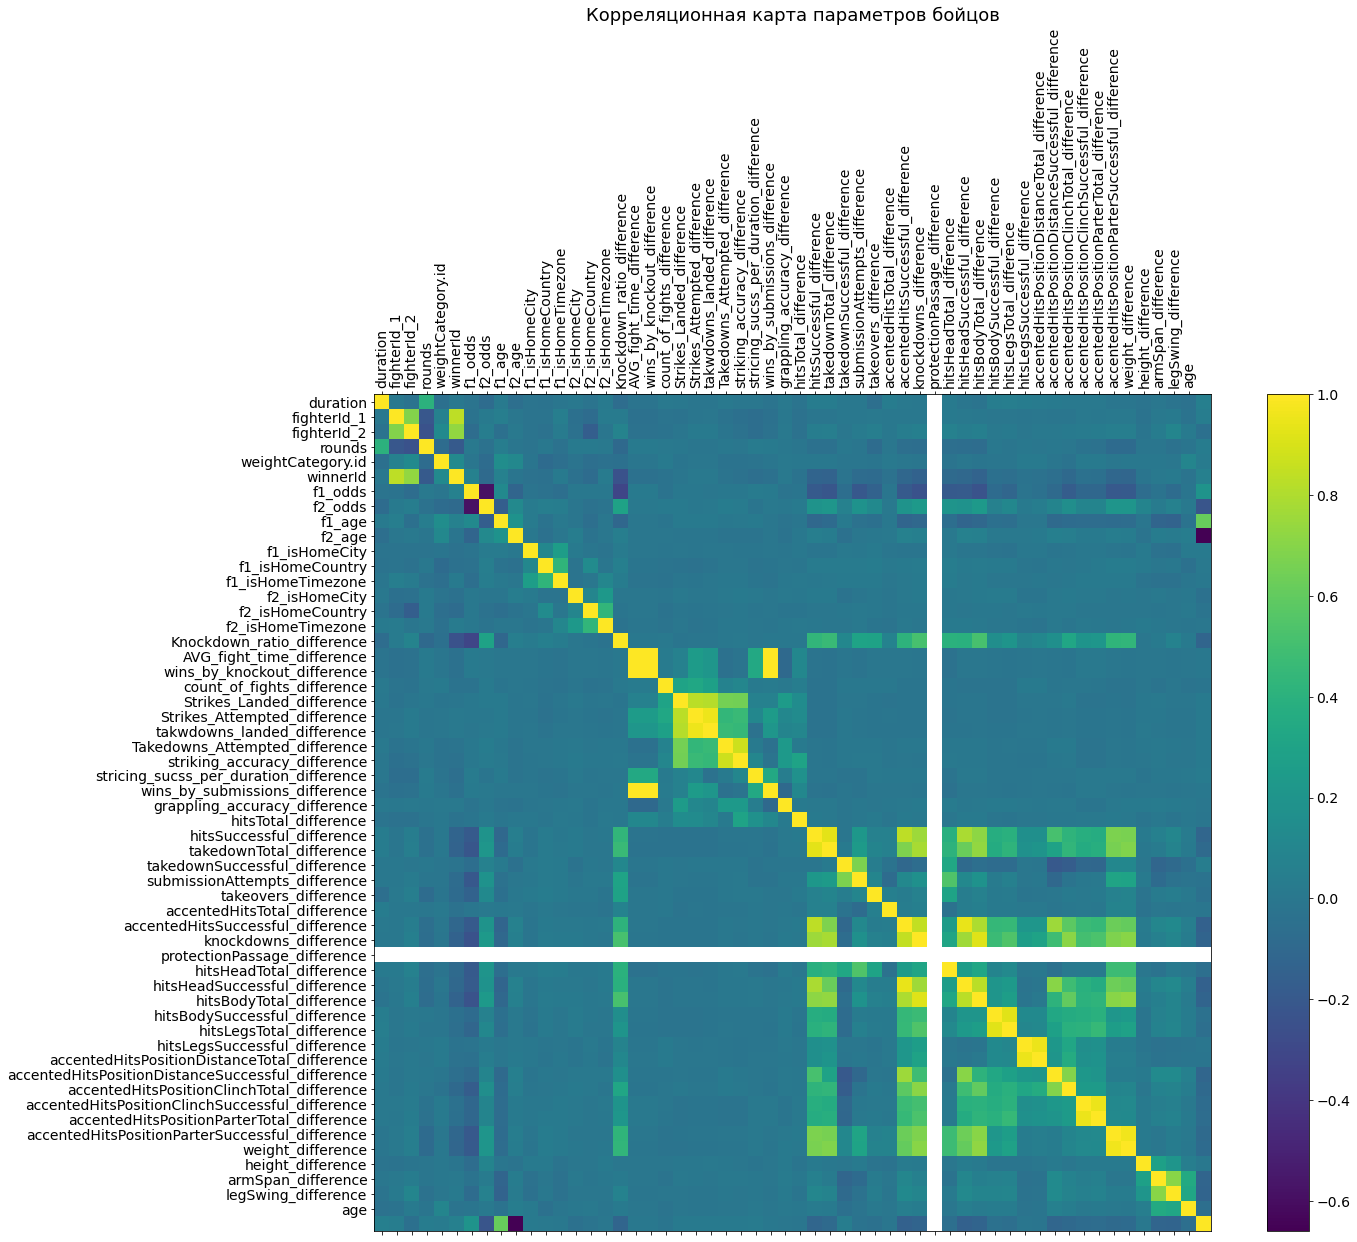

In [354]:
import matplotlib.pyplot as plt

f = plt.figure(figsize=(20, 15))
plt.matshow(df.corr(), fignum=f.number)
plt.xticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14, rotation=90)
plt.yticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Корреляционная карта параметров бойцов', fontsize=18);
# plt.savefig('foo.png')

### Дропаем слишком коррелированные величины

In [355]:
def trimm_correlated(df_in, threshold):
    df_corr = df_in.corr(method='pearson', min_periods=1)
    df_not_correlated = ~(df_corr.mask(np.tril(np.ones([len(df_corr)]*2, dtype=bool))).abs() > threshold).any()
    un_corr_idx = df_not_correlated.loc[df_not_correlated[df_not_correlated.index] == True].index
    df_out = df_in[un_corr_idx]
    return df_out

eventDate = df['eventDate.date'] # Данные по дате и коэф ставок пропадают, поэтому сохраняем их заранее
f1_odds = df['f1_odds']
f2_odds = df['f2_odds']

df = uncorrelated_factors = trimm_correlated(df, 0.5)

cor_col = df.corr(method='pearson', min_periods=1).dropna(axis=1, how='all').columns.tolist()
df = df[cor_col]
df['eventDate.date'] = eventDate
df['f1_odds'] = f1_odds
df['f2_odds'] = f2_odds

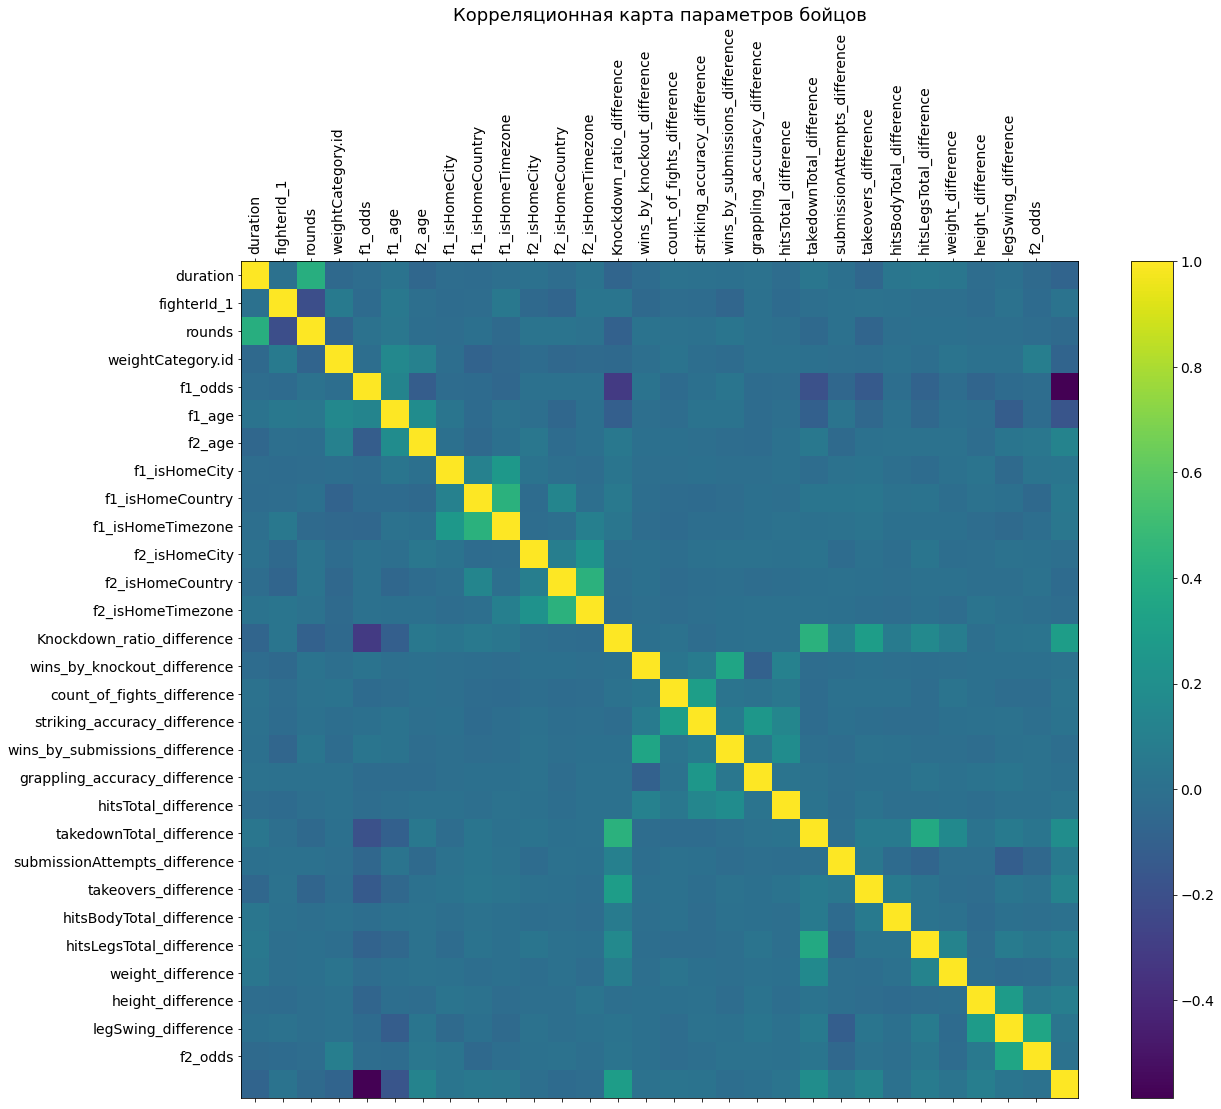

In [356]:
import matplotlib.pyplot as plt

f = plt.figure(figsize=(19, 15))
plt.matshow(df.corr(), fignum=f.number)
plt.xticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14, rotation=90)
plt.yticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Корреляционная карта параметров бойцов', fontsize=18);
# plt.savefig('foo.png')

### Убираем строки, в которых 80 процетов колонок NaN

In [357]:
df.dropna(thresh=round(df.shape[1] * 0.8), inplace=True)

### Избавляемся от лишних колонок в итоговом датафрэйме

In [358]:
df.drop(columns=['fighterId_1', 'weightCategory.id'], inplace=True)

### Для упрощения вычислений внутри модели, оставляем три знака после запятой для всех значений датафрэйма

In [359]:
df = df.round(3)

In [360]:
df.sample(5)

,duration,rounds,f1_odds,f1_age,f2_age,f1_isHomeCity,f1_isHomeCountry,f1_isHomeTimezone,f2_isHomeCity,f2_isHomeCountry,f2_isHomeTimezone,winner,Knockdown_ratio_difference,wins_by_knockout_difference,count_of_fights_difference,striking_accuracy_difference,wins_by_submissions_difference,grappling_accuracy_difference,hitsTotal_difference,takedownTotal_difference,submissionAttempts_difference,takeovers_difference,hitsBodyTotal_difference,hitsLegsTotal_difference,weight_difference,height_difference,legSwing_difference,eventDate.date,f2_odds
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
78,300.0,3.0,1.31,32.0,38.0,0,1,0,0,1,0,True,1.0,0.0,2.0,0.0,0.0,0.0,4.0,2.0,0.0,0.0,0.0,0.0,0.00,7.62,7.62,2019-07-06,4.5
5516,347.0,1.0,NaN,34.0,41.0,0,0,0,0,0,0,True,-4.0,0.0,-12.0,0.0,0.0,0.0,61.0,1.0,1.0,0.0,8.0,1.0,-70.30,-38.10,0.00,2004-12-31,NaN
1927,300.0,3.0,1.87,32.0,36.0,0,1,1,0,1,0,True,1.0,4.0,7.0,1.0,-1.0,-1.0,5.0,-2.0,0.0,0.0,-2.0,5.0,0.00,-2.54,-0.10,2015-07-25,2.1
3125,299.0,1.0,NaN,30.0,26.0,0,1,0,0,1,1,True,0.0,0.0,-1.0,1.0,-1.0,1.0,7.0,1.0,0.0,-1.0,3.0,1.0,0.00,-7.62,-7.72,2012-12-08,NaN
4105,300.0,3.0,NaN,28.0,36.0,0,1,0,0,1,0,True,2.0,0.0,3.0,0.0,0.0,0.0,-15.0,-1.0,1.0,0.0,4.0,1.0,-4.54,0.00,-7.72,2009-05-23,NaN


In [361]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6861 entries, 5201 to 40453
Data columns (total 29 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   duration                        6861 non-null   float64       
 1   rounds                          6861 non-null   float64       
 2   f1_odds                         3567 non-null   float64       
 3   f1_age                          6839 non-null   float64       
 4   f2_age                          6800 non-null   float64       
 5   f1_isHomeCity                   6861 non-null   int64         
 6   f1_isHomeCountry                6861 non-null   int64         
 7   f1_isHomeTimezone               6861 non-null   int64         
 8   f2_isHomeCity                   6861 non-null   int64         
 9   f2_isHomeCountry                6861 non-null   int64         
 10  f2_isHomeTimezone               6861 non-null   int64         
 11  

In [365]:
df.columns

Index(['duration', 'rounds', 'f1_odds', 'f1_age', 'f2_age', 'f1_isHomeCity',
       'f1_isHomeCountry', 'f1_isHomeTimezone', 'f2_isHomeCity',
       'f2_isHomeCountry', 'f2_isHomeTimezone', 'winner',
       'Knockdown_ratio_difference', 'wins_by_knockout_difference',
       'count_of_fights_difference', 'striking_accuracy_difference',
       'wins_by_submissions_difference', 'grappling_accuracy_difference',
       'hitsTotal_difference', 'takedownTotal_difference',
       'submissionAttempts_difference', 'takeovers_difference',
       'hitsBodyTotal_difference', 'hitsLegsTotal_difference',
       'weight_difference', 'height_difference', 'legSwing_difference',
       'eventDate.date', 'f2_odds'],
      dtype='object')

### Конвертируем готовые данные в pickle формат

In [362]:
valid_date = '2019-01-01 00:00:00'
test_date = '2020-01-01 00:00:00'

dates = [valid_date, test_date]
train_df_stats = df[df['eventDate.date'] < valid_date]
valid_df_stats = df[(df['eventDate.date'] > valid_date) & (df['eventDate.date'] < test_date)]
test_df_stats = df[df['eventDate.date'] > test_date]

train_df_stats = df[df['eventDate.date'] < valid_date]
valid_df_stats = df[(df['eventDate.date'] > valid_date) & (df['eventDate.date'] < test_date)]
test_df_stats = df[df['eventDate.date'] > test_date]

train_df_stats.shape, valid_df_stats.shape, test_df_stats.shape

((5901, 29), (513, 29), (447, 29))

In [363]:
train_df_stats.to_pickle('data/train_df_ds2.pkl')
valid_df_stats.to_pickle('data/valid_df_ds2.pkl')
test_df_stats.to_pickle('data/test_df_ds2.pkl')